# Assignment 3 CNN

*(Deep Learning (80240743), Spring 2023)*  
Due at **23:55, March 31, 2023**  


## Instructions

60000 (trainset) + 10000 (testset) Each image is a 28x28 bitmap. 

typical batch of input image data to the neural network  
is a 4D matrix of shape $N \times C \times H \times W$, where $N$ denotes batch size,  
$H$ and $W$ denote height and width of image, and $C$ denotes the number of image  
channels (1)

---

This file is divided into 4 sections:

1.  **Load Dataset**: Code to read dataset file and optionally download them if  
    needed. There's nothing to be done on your part in this section. You may read  
    through this section if you're interested, or you can head straight towards  
    the next section.

2.  **Network Definitions**: This section holds most of your work. You'll complete  
    implentation of several neural network layers in this part. Most classes have  
    three methods: `__init__` used for parameter initialization, `forward` and  
    `backward` for forward and backward propagation respectively. Specifically, you  
    are asked to complete all the `TODO` parts.

    Some of the implementations are identical to those from Assignment 2. You can either  
    reuse your previous code, or wait for mine (will be available at **23:55, March 27**).

3.  **Train**: The actual training part stays in this section. You can freely modify  
    the provided starting code. You'll need to play around with different hyperparameter  
    settings and observe their outcomes. Specifically,

    -   Record training and validation accuracy and plot their graphs.

    -   Compare how **CNN** and **MLP** from Assignment 2 perform differently through  
        various aspects such as training time, convergence, accuracy, etc. The provided  
        hyperparameters might not perform too well. Modify them and observe how they  
        affect classification performance. 

    -   Compare how our network performs differently with and without **Dropout** layer  
        through various aspects. Play with different dropout rates / layer locations  
        and observe the effects.

4.  **Report**: Report your findings from previous section here. Supply your report with  
    data and graphs if necessary.

---

A few things to note:

-   Strive for efficient implementation. Avoid explicit for-loops where matrix multiplication  
    could be used. This is important as the training process may take up to several hours.  
    If you find your training too slow, you may downscale your network, e.g. decrease network  
    hyperparameters, etc.

-   Any neural network framework such as TensorFlow, PyTorch, etc. are **prohibited** in  
    finishing this assignment except for data preprocessing.

-   Cheating/Plagiarism will not be tolerated. Should any submission be found cheating or  
    containing plagiarism, a grade of zero will be given at minimum, and further consequences  
    may arise depending on the circumstances.

-   Late submissions will be deducted by 10% for each day (24h) late in the final grade. 

-   Broken/Incomplete submissions will be graded as-is. Please double check your uploads.


## 1. Load Dataset


In [1]:
import os
import pathlib
import requests
import tqdm
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

from pdb import set_trace as st


In [2]:
# Download dataset from Yann's website

train_images_filename = 'train-images-idx3-ubyte.gz'
train_labels_filename = 'train-labels-idx1-ubyte.gz'
test_images_filename = 't10k-images-idx3-ubyte.gz'
test_labels_filename = 't10k-labels-idx1-ubyte.gz'
gzfilenames = [
    train_images_filename, train_labels_filename,
    test_images_filename, test_labels_filename]

for filename in gzfilenames:
    if not os.path.exists(filename):
        fileurl = f'http://yann.lecun.com/exdb/mnist/{filename}'
        print(f'Downloading from {fileurl} ...')
        r = requests.get(fileurl)
        with open(filename, 'wb') as f:
            _ = f.write(r.content)


In [3]:
# Read from dataset file

validation_size = 5000

def read_mnist_image_set(images_filename):
    with gzip.GzipFile(images_filename, 'rb') as gz:
        magic = int.from_bytes(gz.read(4), 'big')
        assert magic == 2051, f'Not an MNIST image set'

        num_images = int.from_bytes(gz.read(4), 'big')
        rows = int.from_bytes(gz.read(4), 'big')
        cols = int.from_bytes(gz.read(4), 'big')

        data = np.frombuffer(gz.read(num_images * rows * cols), dtype=np.uint8)
        data = np.reshape(data, (num_images, rows, cols))
        return data

def read_mnist_label_set(labels_filename):
    with gzip.GzipFile(labels_filename, 'rb') as gz:
        magic = int.from_bytes(gz.read(4), 'big')
        assert magic == 2049, f'Not an MNIST label set'

        num_labels = int.from_bytes(gz.read(4), 'big')
        labels = np.frombuffer(gz.read(num_labels), dtype=np.uint8)
        return labels

print('\nLoading train set ...')
train_data = read_mnist_image_set(train_images_filename) / np.float32(255)
train_labels = read_mnist_label_set(train_labels_filename)
train_data, val_data = train_data[:-validation_size], train_data[-validation_size:]
train_labels, val_labels = train_labels[:-validation_size], train_labels[-validation_size:]
print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')
print(f'val_data: <np.array of shape: {val_data.shape} dtype: {val_data.dtype}>')
print(f'val_labels: <np.array of shape: {val_labels.shape} dtype: {val_labels.dtype}>')

print('\nLoading test set ...')
test_data = read_mnist_image_set(test_images_filename) / np.float32(255)
test_labels = read_mnist_label_set(test_labels_filename)
print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')



Loading train set ...
train_data: <np.array of shape: (55000, 28, 28) dtype: float32>
train_labels: <np.array of shape: (55000,) dtype: uint8>
val_data: <np.array of shape: (5000, 28, 28) dtype: float32>
val_labels: <np.array of shape: (5000,) dtype: uint8>

Loading test set ...
test_data: <np.array of shape: (10000, 28, 28) dtype: float32>
test_labels: <np.array of shape: (10000,) dtype: uint8>


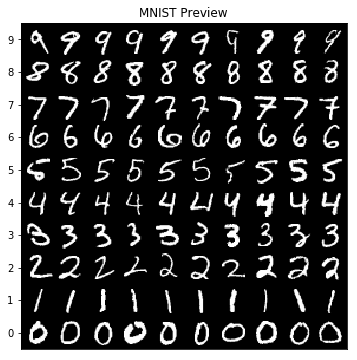

In [4]:
# Preview dataset

_ = plt.figure(figsize=(6, 6))
_ = plt.title('MNIST Preview')
for label in range(10):
    for img_index, img_data in enumerate(test_data[test_labels == label][:10]):
        _ = plt.imshow(
            img_data, 'gray',
            interpolation='nearest', extent=[img_index, img_index + 1, label, label + 1])
_ = plt.xticks([])
_ = plt.yticks(np.arange(10) + 0.5, range(10))
_ = plt.xlim(0, 10)
_ = plt.ylim(0, 10)

## 2. Network Definitions

In [5]:
class Network():
    ''' A simple neural network model with sequential layers '''
    def __init__(self):
        self.layerList = []
        self.numLayer = 0
        self._is_training = True

    @property
    def is_training(self):
        return self._is_training

    @is_training.setter
    def is_training(self, val):
        for layer in self.layerList:
            layer.is_training = val
        self._is_training = val

    def add(self, layer):
        self.numLayer += 1
        self.layerList.append(layer)

    def forward(self, x):
        # forward layer by layer
        for i in range(self.numLayer):
            x = self.layerList[i].forward(x)
        return x

    def backward(self, delta):
        # backward layer by layer
        for i in reversed(range(self.numLayer)): # reversed
            delta = self.layerList[i].backward(delta)


In [6]:
class ReshapeLayer():
    def __init__(self, input_shape, output_shape):
        '''
        Apply the reshape operation to the incoming data
        Args:
            num_input: size of each input sample
            num_output: size of each output sample
        '''
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = False

    def forward(self, Input):
        return Input.reshape(self.output_shape)

    def backward(self, delta):
        return delta.reshape(self.input_shape)


### 2.1 `SGD`, `FCLayer`, `ReLULayer` and `SoftmaxCrossEntropyLossLayer` from Assignment 2

In [7]:
class SGD():
    def __init__(self, learningRate, weightDecay):
        self.learningRate = learningRate
        self.weightDecay = weightDecay

    # One backpropagation step, update weights layer by layer
    def step(self, model):
        layers = model.layerList
        for layer in layers:
            if layer.trainable:

                ############################################################################
                # TODO: Put your code here
                # Calculate diff_W and diff_b using layer.grad_W and layer.grad_b.
                # Do not forget the weightDecay term.
                layer.diff_W = -self.learningRate * (layer.grad_W + self.weightDecay * layer.W)
                layer.diff_b = -self.learningRate * layer.grad_b
                ############################################################################

                # Weight update
                layer.W += layer.diff_W
                layer.b += layer.diff_b


In [8]:
class FCLayer():
    def __init__(self, num_input, num_output, actFunction='relu', trainable=True):
        '''
        Apply a linear transformation to the incoming data: y = Wx + b
        Args:
            num_input: size of each input sample
            num_output: size of each output sample
            actFunction: the name of the activation function such as 'relu', 'sigmoid'
            trainable: whether if this layer is trainable
        '''
        self.num_input = num_input
        self.num_output = num_output
        self.trainable = trainable
        self.actFunction = actFunction
        assert actFunction in ['relu', 'sigmoid']

        self.XavierInit()

        self.grad_W = np.zeros((num_input, num_output))
        self.grad_b = np.zeros((1, num_output))


    def forward(self, Input):

        ############################################################################
        # TODO: Put your code here
        # Apply linear transformation(Wx+b) to Input, and return results.

        self.input = Input
        output = np.dot(self.input, self.W) + self.b
        return output
        ############################################################################


    def backward(self, delta):
        # The delta of this layer has been calculated in the later layer.
        ############################################################################
        # TODO: Put your code here
        # Calculate the gradient using the later layer's gradient: delta

        # self.grad_W and self.grad_b will be used in optimizer.py

        N = delta.shape[0]
        self.grad_W = np.dot(self.input.T, delta) / N
        self.grad_b = np.sum(delta, axis=0, keepdims=True) / N

        return np.dot(delta, self.W.T)
        ############################################################################


    def XavierInit(self):
        # Initialize the weigths according to the type of activation function.
        raw_std = (2 / (self.num_input + self.num_output))**0.5
        if 'relu' == self.actFunction:
            init_std = raw_std * (2**0.5)
        elif 'sigmoid' == self.actFunction:
            init_std = raw_std
        else:
            init_std = raw_std # * 4

        self.W = np.random.normal(0, init_std, (self.num_input, self.num_output))
        self.b = np.random.normal(0, init_std, (1, self.num_output))


In [9]:
class ReLULayer():
    def __init__(self):
        '''
        Applies the rectified linear unit function element-wise: relu(x) = max(x, 0)
        '''
        self.trainable = False # no parameters

    def forward(self, Input):

        ############################################################################
        # TODO: Put your code here
        # Apply ReLU activation function to Input, and return results.

        self.input = Input     # Record the Input for backward calculation
        return np.maximum(Input, 0)
        ############################################################################


    def backward(self, delta):

        ############################################################################
        # TODO: Put your code here
        # Calculate the gradient using the later layer's local sensitivity: delta
        delta[self.input < 0] = 0
        return delta
        ############################################################################

In [10]:
# a small number to prevent dividing by zero, maybe useful for you
EPS = 1e-11

class SoftmaxCrossEntropyLossLayer():
    def __init__(self):
        self.acc = 0.
        self.loss = np.zeros(1, dtype='f')

    def forward(self, logit, gt):
        '''
          Inputs: (minibatch)
          - logit: forward results from the last FCLayer, shape(batch_size, 10)
          - gt: the ground truth label, shape(batch_size, 1)
        '''
        ############################################################################
        # TODO: Put your code here
        # Calculate the average accuracy and loss over the minibatch, and
        # store in self.accu and self.loss respectively.
        # Only return the self.loss, self.accu will be used in solver.py.

        self.gt = gt
        self.prob = np.exp(logit) / (EPS + np.exp(logit).sum(axis=1, keepdims=True))

        # calculate the accuracy
        predict_y = np.argmax(self.prob, axis=1)
        gt_y = np.argmax(gt, axis=1)
        self.acc = np.mean(predict_y == gt_y)

        # calculate the loss
        loss = np.sum(-gt * np.log(self.prob + EPS), axis=1)
        self.loss = np.mean(loss)
        ############################################################################

        return self.loss

    def backward(self):
        ############################################################################
        # TODO: Put your code here
        # Calculate and return the gradient (have the same shape as logit)

        return self.prob - self.gt
        ############################################################################


### 2.2 `ConvLayer` - 2D convolutional layer

This layer contains two trainable parameters $W$ and $b$:

-   $W$ is a tensor of shape $n_{\text{out}} \times n_{\text{in}} \times k \times k$, where
    -   $k$ denotes the convolutional filter (kernel) size;
    -   $n_{\text{in}}$ denotes the number of input channels;
    -   $n_{\text{out}}$ denotes the number of filters.
-   $b$, the filter bias, is a tensor of shape $n_{\text{out}}$.

For simplicity, you only need to implement the standard convolution with stride equal  
to 1. There is another important parameter `pad` that specifies the number of zeros to  
be added to both sides of the input. Therefore the height of output feature maps should  
be $H + 2 \times \text{pad} - \text{kernel\_size} + 1$. Width works similarly.

Hint: You are allowed to use convolution API's from the `scipy.signal` package, though  
this is not a requirement.

In [11]:
from scipy.signal import fftconvolve as convolve

class ConvLayer():
    '''
    2D convolutional layer.
    This layer creates a convolution kernel that is convolved with the layer
    input to produce a tensor of outputs.
    Arguments:
        inputs: Integer, the channels number of input.
        filters: Integer, the number of filters in the convolution.
        kernel_size: Integer, specifying the height and width of the 2D convolution window (height==width in this case).
        pad: Integer, the size of padding area.
        trainable: Boolean, whether this layer is trainable.
    '''
    def __init__(self, inputs, filters, kernel_size, pad, trainable=True):
        self.inputs = inputs
        self.filters = filters
        self.kernel_size = kernel_size
        self.pad = pad
        assert pad < kernel_size, 'pad should be less than kernel_size'
        self.trainable = trainable

        self.XavierInit()

        self.grad_W = np.zeros_like(self.W)
        self.grad_b = np.zeros_like(self.b)

    def XavierInit(self):
        raw_std = (2 / (self.inputs + self.filters)) ** 0.5
        init_std = raw_std * (2 ** 0.5)

        self.W = np.random.normal(0, init_std, (self.filters, self.inputs, self.kernel_size, self.kernel_size))
        self.b = np.random.normal(0, init_std, (self.filters,))

    def forward(self, Input):
        '''
        forward method: perform convolution operation on the input.
        Agrs:
            Input: A batch of images, shape-(batch_size, channels, height, width)
        '''
        ############################################################################
        # TODO: Put your code here
        # Apply convolution operation to Input, and return results.
        # Tips: you can use np.pad() to deal with padding.
        self.Input = Input
        input_after_pad = np.pad(Input, ((0,), (0,), (self.pad,), (self.pad,)), mode='constant', constant_values=0)
        
        # input shape   (batch_size, channels, height, width)
        # W shape       (filters, channels, self.kernel_size, self.kernel_size)
        # output shape  [batch_size, filters, output_height, output_width]
        
        expected_output_shape = (
             Input.shape[0],
             self.filters,
             Input.shape[2] + 2*self.pad + 1 - self.kernel_size,
             Input.shape[3] + 2*self.pad + 1 - self.kernel_size)

        conv_result = np.zeros(expected_output_shape)
        
        for i in range(Input.shape[0]):
            for j in range(self.filters):
                for k in range(self.inputs):
                    conv_result[i][j] += convolve(input_after_pad[i,k], np.rot90(self.W[j,k], 2), mode='valid', axes=(0,1))
        
        conv_result += self.b[np.newaxis, :, np.newaxis, np.newaxis]
        
        return conv_result

        ############################################################################


    def backward(self, delta):
        '''
        backward method: perform back-propagation operation on weights and biases.
        Args:
            delta: Local sensitivity, shape-(batch_size, filters, output_height, output_width)
        Return:
            delta of previous layer
        '''
        ############################################################################
        # TODO: Put your code here
        # Calculate self.grad_W, self.grad_b, and return the new delta.
        
        # delta shape (batch_size, filters, output_height, output_width)
        # W shape     (filters, channels, kernel_size, kernel_size)
        # self.Input  (batch_size, channels, inp_height, inp_width)
        # output shape is the same
        # b shape     (filters,)
        # prev delta shape shld be same as self.Input
        
        batch_size = delta.shape[0]
        
        self.grad_b = np.sum(delta, axis=(0,2,3)) / batch_size
    
        self.grad_W = np.zeros(self.W.shape)
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                for k in range(batch_size):
                    self.grad_W[i][j] += convolve(self.Input[k,j], np.rot90(delta[k,i], 2), mode='valid', axes=(0,1))

        prev_delta = np.zeros(self.Input.shape)
        for i in range(prev_delta.shape[0]):
            for j in range(prev_delta.shape[1]):
                for k in range(self.inputs):
                    prev_delta[i][j] += convolve(delta[i,k], self.W[k,j], mode='same', axes=(0,1))
        
        return prev_delta

        ############################################################################


### 2.3 `MaxPoolingLayer`

You only need to implement a non-overlapping (meaning stride equals to  
kernel size) max-pooling layer here. The output should have height  
$(H + 2 \times \text{pad}) / \text{kernel\_size}$. Width works similarly.

In [12]:
class MaxPoolingLayer():
    def __init__(self, kernel_size, pad):
        '''
        This class performs max pooling operation on the input.
        Args:
            kernel_size: The height/width of the pooling kernel.
            pad: The width of the pad zone.
        '''

        self.kernel_size = kernel_size
        self.pad = pad
        self.trainable = False

    def forward(self, Input):
        '''
        This method performs max pooling operation on the input.
        Args:
            Input: The input need to be pooled.
        Return:
            The tensor after being pooled.
        '''
        ############################################################################
        # TODO: Put your code here
        # Apply convolution operation to Input, and return results.
        # Tips: you can use np.pad() to deal with padding.
        self.Input = Input
        input_after_pad = np.pad(Input, ((0,), (0,), (self.pad,), (self.pad,)), mode='constant', constant_values=0)
        kernel_mult_1 = (int)(input_after_pad.shape[2] / self.kernel_size)
        kernel_mult_2 = (int)(input_after_pad.shape[3] / self.kernel_size)

        output = np.zeros((input_after_pad.shape[0], input_after_pad.shape[1], kernel_mult_1, kernel_mult_2))
        bigger_output = np.zeros(input_after_pad.shape)
        for i in range(kernel_mult_1):
            for j in range(kernel_mult_2):
                this_max = np.max(input_after_pad[:,:,i*self.kernel_size:(i+1)*self.kernel_size,j*self.kernel_size:(j+1)*self.kernel_size], axis=(2,3))
                output[:,:,i,j] = this_max
                stacked_tm = np.stack([this_max, this_max], 2)
                bigger_output[:,:,i*self.kernel_size:(i+1)*self.kernel_size,j*self.kernel_size:(j+1)*self.kernel_size] = np.stack([stacked_tm, stacked_tm], 3)
            
        self.mask = (bigger_output == input_after_pad)
        return output

        ############################################################################

    def backward(self, delta):
        '''
        Args:
            delta: Local sensitivity, shape-(batch_size, filters, output_height, output_width)
        Return:
            delta of previous layer
        '''
        ############################################################################
        # TODO: Put your code here
        # Calculate and return the new delta.

        big_delta = np.zeros(self.mask.shape)
        
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                big_delta[:,:,i::self.kernel_size,j::self.kernel_size] = delta[:,:,:,:]
        
        return big_delta * self.mask

        ############################################################################


### 2.4 `DropoutLayer`

Note that dropout should be applied during training only.

In [13]:
class DropoutLayer():
    def __init__(self, dropout_rate=0):
        self.dropout_rate = dropout_rate
        self.trainable = False
        self.is_training = True

    def forward(self, Input):

        ############################################################################
        # TODO: Put your code here
        if self.is_training:
            rand_mat = np.random.rand(*Input.shape)
            self.dropout_mask = rand_mat >= self.dropout_rate
            return np.multiply(Input, self.dropout_mask)
            
        else: #not training -- use mean network
            return Input * (1 - self.dropout_rate)

        ############################################################################

    def backward(self, delta):

        ############################################################################
        # TODO: Put your code here

        return np.multiply(delta, self.dropout_mask)

        ############################################################################


## 3. Train

You may freely modify any given template code as you see fit.


In [14]:
# Hyperparameters

batch_size = 20
max_epoch = 5
init_std = 0.01

learning_rate = 0.001
weight_decay = 0.005


In [15]:
def train(model, criterion, optimizer):
    all_train_losses, all_train_accs = [], []
    avg_train_losses, avg_train_accs = [], []
    avg_val_losses, avg_val_accs = [], []

    # Training process
    for epoch in range(max_epoch):
        # Train one epoch
        batch_train_losses, batch_train_accs = [], []

        steps_per_epoch = np.ceil(len(train_data) / batch_size).astype(int)
        batch_split_indices = np.arange(batch_size, len(train_data), batch_size)
        train_data_batches = np.split(train_data, batch_split_indices)
        train_labels_batches = np.split(train_labels, batch_split_indices)

        model.is_training = True
        progress_bar = tqdm.tqdm(range(steps_per_epoch), desc=f'Ep[{epoch}]', position=0, leave=True)
        for step_index in progress_bar:
            # Get train data and label
            x = train_data_batches[step_index][:, None]             # x.shape: [batch_size, 1, 28, 28]
            y_true = np.eye(10)[train_labels_batches[step_index]]   # y_true.shape (one-hot): [batch_size, 10]

            # Forward pass
            y_pred = model.forward(x)
            criterion.forward(y_pred, y_true)

            # Backward pass
            delta = criterion.backward()
            model.backward(delta)

            # Update weights, see optimize.py
            optimizer.step(model)

            # Record loss and accuracy
            batch_train_losses.append(criterion.loss)
            batch_train_accs.append(criterion.acc)
            progress_bar.set_description(f'Ep[{epoch}] loss:{criterion.loss:.3f} acc:{criterion.acc:.3f}')

        model.is_training = False

        # Validate
        # Get validating data and label
        x = val_data[:, None]               # x.shape: [batch_size, 1, 28, 28]
        y_true = np.eye(10)[val_labels]     # y_true.shape (one-hot): [batch_size, 10]

        # Only forward pass
        y_pred = model.forward(x)
        criterion.forward(y_pred, y_true)

        # Record loss and accuracy
        val_loss = criterion.loss
        val_acc = criterion.acc

        all_train_losses.extend(batch_train_losses)
        all_train_accs.extend(batch_train_accs)
        avg_train_losses.append(np.mean(batch_train_losses))
        avg_train_accs.append(np.mean(batch_train_accs))
        avg_val_losses.append(np.mean(val_loss))
        avg_val_accs.append(np.mean(val_acc))
        print(f'  - Val loss:{avg_val_losses[-1]:.4f} acc:{avg_val_accs[-1]:.4f}')

    # Test
    x = test_data[:, None]              # x.shape: [batch_size, 1, 28, 28]
    y_true = np.eye(10)[test_labels]    # y_true.shape (one-hot): [batch_size, 10]

    # Only forward pass
    y_pred = model.forward(x)
    criterion.forward(y_pred, y_true)

    test_acc = criterion.acc
    print(f'\nTest acc is {test_acc:.4f}\n')

    # plot loss & accuracy curve
    x_by_epoch = (np.arange(max_epoch) + 1) * steps_per_epoch
    fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 4))
    _ = a0.set_title('Losses')
    _ = a0.plot(all_train_losses, alpha=0.5, label='train (all)')
    _ = a0.plot(x_by_epoch, avg_train_losses, marker='.', label='train')
    _ = a0.plot(x_by_epoch, avg_val_losses, marker='.', label='val')
    _ = a0.set_yscale('log')
    _ = a0.legend()
    _ = a1.set_title('Accuracies')
    _ = a1.plot(all_train_accs, alpha=0.5, label='train (all)')
    _ = a1.plot(x_by_epoch, avg_train_accs, marker='.', label='train')
    _ = a1.plot(x_by_epoch, avg_val_accs, marker='.', label='val')
    _ = a1.legend()

    return model, avg_val_losses, avg_val_accs


Ep[1]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.3428 acc:0.8908


Ep[2]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2449 acc:0.9260


Ep[3]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2070 acc:0.9382


Ep[4]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.1841 acc:0.9446


Ep[4] loss:0.328 acc:0.800: 100%|█████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [1:42:48<00:00,  2.24s/it]


  - Val loss:0.1708 acc:0.9484

Test acc is 0.9349



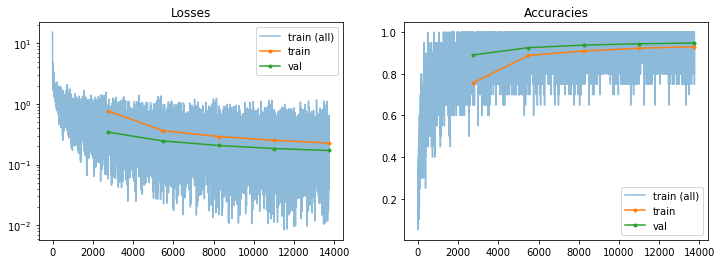

In [17]:
convNet = Network()
convNet.add(ConvLayer(1, 4, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(ConvLayer(4, 8, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(ReshapeLayer((-1, 8, 7, 7), (-1, 392)))
convNet.add(FCLayer(392, 64))
convNet.add(ReLULayer())
convNet.add(FCLayer(64, 10))

criterion = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate, weight_decay)

convNet, avg_val_losses, avg_val_accs = train(convNet, criterion, sgd)


Ep[1]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.7662 acc:0.7692


Ep[2]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.4742 acc:0.8636


Ep[3]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.3810 acc:0.8964


Ep[4]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.3262 acc:0.9106


Ep[4] loss:0.723 acc:0.800: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [49:54<00:00,  1.09s/it]


  - Val loss:0.2939 acc:0.9180

Test acc is 0.8954



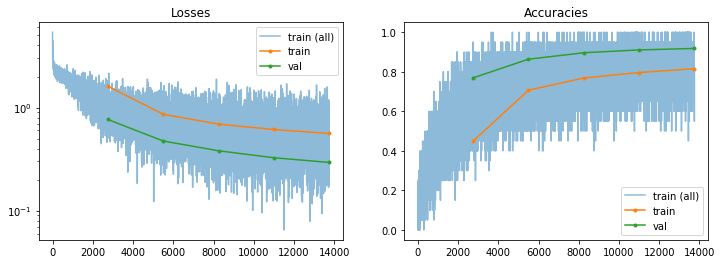

In [24]:
# the one above shld be done running. see the results and run this one too.


# TODO: Build your own network with dropout layer

convNet = Network()
convNet.add(ConvLayer(1, 4, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.1))
convNet.add(ConvLayer(4, 8, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.1))
convNet.add(ReshapeLayer((-1, 8, 7, 7), (-1, 392)))
convNet.add(FCLayer(392, 64))
convNet.add(ReLULayer())
convNet.add(FCLayer(64, 10))

criterion = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate, weight_decay)

convNet, avg_val_losses, avg_val_accs = train(convNet, criterion, sgd)


Ep[1]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.3545 acc:0.8934


Ep[2]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2562 acc:0.9210


Ep[3]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2077 acc:0.9354


Ep[4]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2032 acc:0.9372


Ep[4] loss:0.343 acc:0.950: 100%|█████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [1:05:51<00:00,  1.44s/it]


  - Val loss:0.1732 acc:0.9484

Test acc is 0.9365



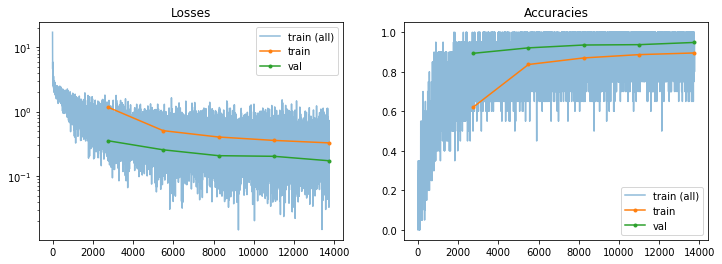

In [25]:
# TODO: Build your own network with dropout layer

convNet = Network()
convNet.add(ConvLayer(1, 4, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.05))
convNet.add(ConvLayer(4, 8, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.05))
convNet.add(ReshapeLayer((-1, 8, 7, 7), (-1, 392)))
convNet.add(FCLayer(392, 64))
convNet.add(ReLULayer())
convNet.add(FCLayer(64, 10))

criterion = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate, weight_decay)

convNet, avg_val_losses, avg_val_accs = train(convNet, criterion, sgd)


Ep[1]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.3484 acc:0.8980


Ep[2]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2645 acc:0.9208


Ep[3]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2433 acc:0.9298


Ep[4]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2311 acc:0.9298


Ep[5]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2183 acc:0.9338


Ep[6]:   0%|                                                                                                                       | 0/2750 [00:00<?, ?it/s]

  - Val loss:0.2186 acc:0.9328


Ep[6] loss:0.182 acc:0.900: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [58:59<00:00,  1.29s/it]


  - Val loss:0.2078 acc:0.9398

Test acc is 0.9229



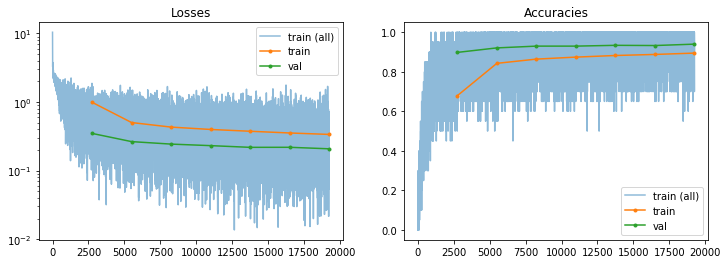

In [16]:
# Hyperparameters

batch_size = 20
max_epoch = 7
init_std = 0.01
learning_rate = 0.001
weight_decay = 0.005


# using the best model from earlier

convNet = Network()
convNet.add(ConvLayer(1, 4, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.03))
convNet.add(ConvLayer(4, 8, 3, 1))
convNet.add(ReLULayer())
convNet.add(MaxPoolingLayer(2, 0))
convNet.add(DropoutLayer(dropout_rate=0.03))
convNet.add(ReshapeLayer((-1, 8, 7, 7), (-1, 392)))
convNet.add(FCLayer(392, 64))
convNet.add(ReLULayer())
convNet.add(FCLayer(64, 10))

criterion = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate, weight_decay)

convNet, avg_val_losses, avg_val_accs = train(convNet, criterion, sgd)

## 4. Report

First of all, we note that the CNN implementation is able to learn from the data. Moreover, it is able to perform quite well (around 0.90-0.95 accuracy), which is to be expected since CNNs are specially catered to computer vision tasks like MNIST. This implies our CNN implementation works and is effective.

The first CNN implementation provided achieved a test accuracy of 0.9349 using the default hyperparameters. This is actually quite good; for reference, the default implementation of an MLP with default hyperparameters in assignment 2 gave a test accuracy of 0.8932, which is slightly worse. This is unsurprising as the CNN is specialized to deal with computer vision tasks unlike the MLP. 

After the first implementation of the CNN, we tried adding two dropout layers after the max pooling layers. The dropout rate was 0.1. This gave a test accuracy of 0.8954, which was a slight decrease from the first attempt. It suggests the dropout level is too high.

We tried again with a dropout rate of 0.05 instead. This time the model performed slightly better than the first attempt, giving a test accuracy of 0.9365.

For that model, we noticed the validation accuracy was still increasing when the epochs ended. This suggested that the model may not have converged fully and that there was still a bit of room for improvement. Hence we increased epochs to 7. The test accuracy was 0.9229. This might suggest some overfitting. So the best model was still the previous one.

Overall the best accuracy for the CNN was 0.9365.


